# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

**Group Members**
- Naikaj Pandya
- Chase Madson
- Eric Danforth


# I. Setup

## A. Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For feature engineering
from decimal import Decimal

# For splitting data 
from sklearn.model_selection import train_test_split

# For preprocessing
from sklearn.preprocessing import minmax_scale, OneHotEncoder

# For fitting
import tensorflow as tf

# For model evalutaion
from sklearn.metrics import roc_curve, auc

## B. Connect to TPU
Navigate to Edit→Notebook Settings
select TPU from the Hardware Accelerator drop-down, and High-RAM Runtime

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.59.86.50:8470']


## C. Load Data

### Run the following in a kaggle notebook for the current gcs link:
```
from kaggle_datasets import KaggleDatasets
KaggleDatasets().get_gcs_path()
```

In [3]:
from google.colab import auth
auth.authenticate_user()
! echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list 
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add - 
! apt update 
! apt install gcsfuse 
! mkdir -p 'ieee-fraud-detection'
! gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 'kds-736d2b976458a9f97a40a072c8624c2de9e65455a381ffdae66caa06' 'ieee-fraud-detection' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k
OK
Hit:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic

In [4]:
# Load Data
train = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
test = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
sub = pd.read_csv('ieee-fraud-detection/sample_submission.csv').drop('isFraud', axis=1)

In [5]:
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv')
test_id = pd.read_csv('ieee-fraud-detection/test_identity.csv')

In [6]:
import re
test_id = test_id.rename(columns=lambda x: re.sub('-','_',x))

## D. Feature Engineering

### 1. Custom Groupings for Purchaser and Recipient Domains

To use the purchaser and recipient domain email addresses, we create a highly customized categorical variable called `custom_domain_grouping`. 

This uses a switch statement to condense information about:

1. Drop the domain extensions so "gmail.com" and "gmail" are placed into same group
2. Whether recipient, purchaser, or both email addresses are null
3. Whether the recipient and purchaser domain address matched (e.g., gmail to gmail)
4. If the recipient and purchaser domain addresses do match, what domain is it?

In [7]:
def get_custom_domain_grouping(df_train, df_test):
    """This function is disgusting but gives us good categories from the domain addresses"""

    # Remove the domain extensions on all variables
    df_train['purch_domain_name'] = df_train.P_emaildomain.str.replace('\..*', '', regex=True)
    df_train['recip_domain_name'] = df_train.R_emaildomain.str.replace('\..*', '', regex=True)
    df_test['purch_domain_name'] = df_test.P_emaildomain.str.replace('\..*', '', regex=True)
    df_test['recip_domain_name'] = df_test.R_emaildomain.str.replace('\..*', '', regex=True)

    # Get the list of top 95% of email domains in the _training_ set only 
    top_95pct_purch_domains = (
        df_train.purch_domain_name
        .value_counts(normalize=True)
        .rename_axis('factor_levels')
        .cumsum()
        .reset_index(name='cumsum')
        .query('cumsum<0.95')
        .sort_values('cumsum')
        .factor_levels
        .tolist()   
    )
    
    # This switch statement is based on 
    custom_domain_grouping_train = np.select(
        condlist = [
            # Create a group for null recipients
            df_train.R_emaildomain.isnull(),
            # Create a group for null purchasers (when recipient not null)
            df_train.P_emaildomain.isnull(),
            # Create a group for purchaser domains paired with a distinct recipient domain
            df_train.purch_domain_name != df_train.recip_domain_name,
            # If domains match and in our most common domains 
            df_train.purch_domain_name.isin(top_95pct_purch_domains)
            ], 
        choicelist = [
            'Recipient or Both Blank',
            'Just Purchaser Blank',
            'Purchaser and Recipient Differ',
            'Purchaser and Recipient Same: ' + df_train.purch_domain_name
            ],
        default='Purchaser and Recipient Same: other domain'
    )

    # Do the same as above, but for the test set
    custom_domain_grouping_test = np.select(
        condlist = [
            df_test.R_emaildomain.isnull(),
            df_test.P_emaildomain.isnull(),
            df_test.purch_domain_name != df_test.recip_domain_name,
            df_test.purch_domain_name.isin(top_95pct_purch_domains)
            ], 
        choicelist = [
            'Recipient or Both Blank',
            'Just Purchaser Blank',
            'Purchaser and Recipient Differ',
            'Purchaser and Recipient Same: ' + df_test.purch_domain_name
            ],
        default='Purchaser and Recipient Same: other domain'
    )

    return custom_domain_grouping_train, custom_domain_grouping_test

train['custom_domain_grouping'], test['custom_domain_grouping'] = get_custom_domain_grouping(train, test)

### 3. Feature Engineering: Whether Currency has More than Two Decimals

In [8]:
def txn_usd_convert(amt):
    return np.float16(-Decimal(str(amt)).as_tuple().exponent > 2)

train['Transaction_curr_type'] = train['TransactionAmt'].apply(txn_usd_convert)
test['Transaction_curr_type'] = test['TransactionAmt'].apply(txn_usd_convert)

### 4. Feature Engineering: User ID

In [9]:
train['uid'] = train['ProductCD'].astype(str) + '_' + \
  train['card1'].astype(str) + '_' + \
  train['card4'].astype(str) + '_' + \
  train['card6'].astype(str) + '_' + \
  train['addr1'].astype(str) + '_' + \
  train['dist1'].astype(str) + '_' + \
  train['dist2'].astype(str) + '_' + \
  train['P_emaildomain'].astype(str) + '_' + \
  train['C13'].astype(str)
train['uid'] = train['uid'].apply(lambda x: hash(x))

test['uid'] = test['ProductCD'].astype(str) + '_' + \
  test['card1'].astype(str) + '_' + \
  test['card4'].astype(str) + '_' + \
  test['card6'].astype(str) + '_' + \
  test['addr1'].astype(str) + '_' + \
  test['dist1'].astype(str) + '_' + \
  test['dist2'].astype(str) + '_' + \
  test['P_emaildomain'].astype(str) + '_' + \
  test['C13'].astype(str)
  
test['uid'] = test['uid'].apply(lambda x: hash(x))

In [11]:
train = train.merge(train_id, how='left', on='TransactionID')
train1 = train[train['id_01'].isnull()]
train1 = train1.iloc[:,:-39]
train2 = train[~train['id_01'].isnull()]
train3 = train2.iloc[:,-41:].drop_duplicates(subset=['uid'])
train1 = train1.merge(train3, how='left', on='uid')
train = pd.concat([train1, train2])
del train1, train2, train3
train = train.sort_values("TransactionID",ascending=True)

In [14]:
test = test.merge(test_id, how='left', on='TransactionID')
test1 = test[test['id_01'].isnull()]
test1 = test1.iloc[:,:-39]
test2 = test[~test['id_01'].isnull()]
test3 = test2.iloc[:,-41:].drop_duplicates(subset=['uid'])
test1 = test1.merge(test3, how='left', on='uid')
test = pd.concat([test1, test2])
del test1, test2, test3
test = test.sort_values("TransactionID",ascending=True)

## E. Group the Columns

In [15]:
# Transaction payment amount in USD
features_num_amt = train[['TransactionAmt']].columns

# Date and time of transactions
features_num_dt = train[['TransactionDT']].columns

# Distance measures between two masked points
features_num_dist = train.filter(regex='^dist').columns

# Various (masked) counts, e.g. how many addresses associated with payment card
features_num_C = train.filter(regex='^C').columns

# Various (masked) timedeltas, e.g. days between previous transactions
features_num_D = train.filter(regex='^D[0-9]').columns

# Various (masked) Vesta engineered rich features
features_num_V = train.filter(regex='^V').columns

# uid
features_uid = train[['uid']].columns

features_id_num = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_24', 'id_25', 'id_26', ]

features_num = (
    features_num_amt
    .union(features_num_dt)
    .union(features_num_dist)
    .union(features_num_C)
    .union(features_num_D)
    .union(features_num_V)
    .union(features_uid)
    .union(features_id_num)
)

In [16]:
# Product code for the product associated with the transaction
features_cat_CD = train[['ProductCD']].columns

# Payment card information, such as card type, card category, issue bank, country
# features_cat_card = train.filter(regex='^card').columns
features_cat_card4 = train.filter(regex='^card4').columns
features_cat_card6 = train.filter(regex='^card6').columns

# Address (unspecified)
features_cat_addr = train.filter(regex='^addr').columns

# Purchaser and recipient email domains
features_cat_domain = train[['custom_domain_grouping']].columns

# Various matches (masked), e.g. names on card and addresses
features_cat_M = train.filter(regex='^M').columns

# New feature - whether the transaction amount had more than 2 decimal places
features_cat_curr_type = train[['Transaction_curr_type']].columns

features_id = ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',]
features_device = train.filter(regex='^Device').columns

features_cat = (
    features_cat_CD
    # .union(features_cat_card)
    .union(features_cat_card4)
    .union(features_cat_card6)
    .union(features_cat_addr)
    .union(features_cat_domain)
    .union(features_cat_M)
    .union(features_cat_curr_type)
    .union(features_id)
    #.union(features_device)
)

In [17]:
# Define the sets of features used, by variable type 
features = features_num.union(features_cat)

# Define our ID column and target
id = train[['TransactionID']].columns
target = train[['isFraud']].columns

# Select relevant columns
train = train[target.union(features)]
test = test[features]

print(f'We start with {len(features)} available features: {len(features_num)} numeric and {len(features_cat)} categorical.')

We start with 426 available features: 395 numeric and 31 categorical.


# II. Data Preparation

## A. Split Data into Train and Validation

In [18]:
# Save 30% of the training data for validation
training, validation = train_test_split(train, test_size=0.3, random_state=1)

# With the remaining 70% in the training set, downsample the majority class
training = (
    training
    .groupby('isFraud')
    .sample(
        n=sum(training.isFraud == 1),
        random_state=1
    )
)

# Separate the features from the label
y_train = training[['isFraud']]
y_val = validation[['isFraud']]
X_train = training[features]
X_val = validation[features]

# Drop unneeded DataFrames
del training, validation

## B. Preprocessing Numeric Values

Apply Min-Max normalization and replace missing values for all numeric features in training, validation, and test sets

In [19]:
def replace_na_and_normalize(df, cols=features_num):
    return (df[cols]
        .apply(lambda var: var.fillna(var.min() - 2))
        .apply(minmax_scale, feature_range=(0,1))
    )

X_train[features_num] = replace_na_and_normalize(X_train)
X_val[features_num] = replace_na_and_normalize(X_val)
test[features_num] = replace_na_and_normalize(test)

## C. Preprocessing Categorical Values

Replace raw categorical features with one-hot encoding values

In [20]:
sys_dict = {'Android':'Android', 
'Android 4.4.2':'Android', 
'Android 5.0':'Android', 
'Android 5.0.2':'Android', 
'Android 5.1.1':'Android', 
'Android 6.0':'Android', 
'Android 6.0.1':'Android', 
'Android 7.0':'Android', 
'Android 7.1.1':'Android', 
'Android 7.1.2':'Android', 
'Android 8.0.0':'Android', 
'Android 8.1.0':'Android', 
'Android 9':'Android', 
'func':'func', 
'iOS':'iOS', 
'iOS 10.0.2':'iOS', 
'iOS 10.1.1':'iOS', 
'iOS 10.2.0':'iOS', 
'iOS 10.2.1':'iOS', 
'iOS 10.3.1':'iOS', 
'iOS 10.3.2':'iOS', 
'iOS 10.3.3':'iOS', 
'iOS 11.0.0':'iOS', 
'iOS 11.0.1':'iOS', 
'iOS 11.0.2':'iOS', 
'iOS 11.0.3':'iOS', 
'iOS 11.1.0':'iOS', 
'iOS 11.1.1':'iOS', 
'iOS 11.1.2':'iOS', 
'iOS 11.2.0':'iOS', 
'iOS 11.2.1':'iOS', 
'iOS 11.2.2':'iOS', 
'iOS 11.2.5':'iOS', 
'iOS 11.2.6':'iOS', 
'iOS 11.3.0':'iOS', 
'iOS 11.3.1':'iOS', 
'iOS 11.4.0':'iOS', 
'iOS 11.4.1':'iOS', 
'iOS 12.0.0':'iOS', 
'iOS 12.0.1':'iOS', 
'iOS 12.1.0':'iOS', 
'iOS 12.1.1':'iOS', 
'iOS 12.1.2':'iOS', 
'iOS 9.3.5':'iOS', 
'Linux':'Linux', 
'Mac':'Mac', 
'Mac OS X 10.10':'Mac', 
'Mac OS X 10.11':'Mac', 
'Mac OS X 10.12':'Mac', 
'Mac OS X 10.13':'Mac', 
'Mac OS X 10.14':'Mac', 
'Mac OS X 10.6':'Mac', 
'Mac OS X 10.9':'Mac', 
'Mac OS X 10_10_5':'Mac', 
'Mac OS X 10_11_3':'Mac', 
'Mac OS X 10_11_4':'Mac', 
'Mac OS X 10_11_5':'Mac', 
'Mac OS X 10_11_6':'Mac', 
'Mac OS X 10_12':'Mac', 
'Mac OS X 10_12_1':'Mac', 
'Mac OS X 10_12_2':'Mac', 
'Mac OS X 10_12_3':'Mac', 
'Mac OS X 10_12_4':'Mac', 
'Mac OS X 10_12_5':'Mac', 
'Mac OS X 10_12_6':'Mac', 
'Mac OS X 10_13_1':'Mac', 
'Mac OS X 10_13_2':'Mac', 
'Mac OS X 10_13_3':'Mac', 
'Mac OS X 10_13_4':'Mac', 
'Mac OS X 10_13_5':'Mac', 
'Mac OS X 10_13_6':'Mac', 
'Mac OS X 10_14':'Mac', 
'Mac OS X 10_14_0':'Mac', 
'Mac OS X 10_14_1':'Mac', 
'Mac OS X 10_14_2':'Mac', 
'Mac OS X 10_6_8':'Mac', 
'Mac OS X 10_7_5':'Mac', 
'Mac OS X 10_8_5':'Mac', 
'Mac OS X 10_9_5':'Mac', 
'other':'other', 
'Windows':'Windows', 
'Windows 10':'Windows', 
'Windows 7':'Windows', 
'Windows 8':'Windows', 
'Windows 8.1':'Windows', 
'Windows Vista':'Windows', 
'Windows XP':'Windows', }

In [21]:
browser_dict = {'android':'android', 
'android browser 4.0':'android', 
'android webview 4.0':'android', 
'aol':'aol', 
'blackberry':'blackberry', 
'Cherry':'Cherry', 
'chrome':'chrome', 
'chrome 39.0 for android':'chrome', 
'chrome 43.0 for android':'chrome', 
'chrome 46.0 for android':'chrome', 
'chrome 49.0':'chrome', 
'chrome 49.0 for android':'chrome', 
'chrome 50.0 for android':'chrome', 
'chrome 51.0':'chrome', 
'chrome 51.0 for android':'chrome', 
'chrome 52.0 for android':'chrome', 
'chrome 53.0 for android':'chrome', 
'chrome 54.0 for android':'chrome', 
'chrome 55.0':'chrome', 
'chrome 55.0 for android':'chrome', 
'chrome 56.0':'chrome', 
'chrome 56.0 for android':'chrome', 
'chrome 57.0':'chrome', 
'chrome 57.0 for android':'chrome', 
'chrome 58.0':'chrome', 
'chrome 58.0 for android':'chrome', 
'chrome 59.0':'chrome', 
'chrome 59.0 for android':'chrome', 
'chrome 60.0':'chrome', 
'chrome 60.0 for android':'chrome', 
'chrome 61.0':'chrome', 
'chrome 61.0 for android':'chrome', 
'chrome 62.0':'chrome', 
'chrome 62.0 for android':'chrome', 
'chrome 62.0 for ios':'chrome', 
'chrome 63.0':'chrome', 
'chrome 63.0 for android':'chrome', 
'chrome 63.0 for ios':'chrome', 
'chrome 64.0':'chrome', 
'chrome 64.0 for android':'chrome', 
'chrome 64.0 for ios':'chrome', 
'chrome 65.0':'chrome', 
'chrome 65.0 for android':'chrome', 
'chrome 65.0 for ios':'chrome', 
'chrome 66.0':'chrome', 
'chrome 66.0 for android':'chrome', 
'chrome 66.0 for ios':'chrome', 
'chrome 67.0':'chrome', 
'chrome 67.0 for android':'chrome', 
'chrome 67.0 for ios':'chrome', 
'chrome 68.0':'chrome', 
'chrome 68.0 for android':'chrome', 
'chrome 68.0 for ios':'chrome', 
'chrome 69.0':'chrome', 
'chrome 69.0 for android':'chrome', 
'chrome 69.0 for ios':'chrome', 
'chrome 70.0':'chrome', 
'chrome 70.0 for android':'chrome', 
'chrome 70.0 for ios':'chrome', 
'chrome 71.0':'chrome', 
'chrome 71.0 for android':'chrome', 
'chrome 71.0 for ios':'chrome', 
'chrome generic':'chrome', 
'chrome generic for android':'chrome', 
'comodo':'comodo', 
'cyberfox':'cyberfox', 
'edge':'edge', 
'edge 13.0':'edge', 
'edge 14.0':'edge', 
'edge 15.0':'edge', 
'edge 16.0':'edge', 
'edge 17.0':'edge', 
'edge 18.0':'edge', 
'facebook':'facebook', 
'firefox':'firefox', 
'firefox 47.0':'firefox', 
'firefox 48.0':'firefox', 
'firefox 52.0':'firefox', 
'firefox 55.0':'firefox', 
'firefox 56.0':'firefox', 
'firefox 57.0':'firefox', 
'firefox 58.0':'firefox', 
'firefox 59.0':'firefox', 
'firefox 60.0':'firefox', 
'firefox 61.0':'firefox', 
'firefox 62.0':'firefox', 
'firefox 63.0':'firefox', 
'firefox 64.0':'firefox', 
'firefox generic':'firefox', 
'firefox mobile 61.0':'firefox', 
'firefox mobile 62.0':'firefox', 
'firefox mobile 63.0':'firefox', 
'Generic/Android':'Generic', 
'Generic/Android 7.0':'Generic', 
'google':'google', 
'google search application 48.0':'google', 
'google search application 49.0':'google', 
'google search application 52.0':'google', 
'google search application 54.0':'google', 
'google search application 56.0':'google', 
'google search application 58.0':'google', 
'google search application 59.0':'google', 
'google search application 60.0':'google', 
'google search application 61.0':'google', 
'google search application 62.0':'google', 
'google search application 63.0':'google', 
'google search application 64.0':'google', 
'google search application 65.0':'google', 
'icedragon':'icedragon', 
'ie':'ie', 
'ie 11.0 for desktop':'ie', 
'ie 11.0 for tablet':'ie', 
'Lanix/Ilium':'Lanix', 
'line':'line', 
'maxthon':'maxthon', 
'Microsoft/Windows':'Microsoft', 
'mobile':'mobile', 
'mobile safari 10.0':'mobile', 
'mobile safari 11.0':'mobile', 
'mobile safari 12.0':'mobile', 
'mobile safari 8.0':'mobile', 
'mobile safari 9.0':'mobile', 
'mobile safari generic':'mobile', 
'mobile safari uiwebview':'mobile', 
'Mozilla/Firefox':'Mozilla', 
'opera':'opera', 
'opera 49.0':'opera', 
'opera 51.0':'opera', 
'opera 52.0':'opera', 
'opera 53.0':'opera', 
'opera 54.0':'opera', 
'opera 55.0':'opera', 
'opera 56.0':'opera', 
'opera generic':'opera', 
'other':'other', 
'palemoon':'palemoon', 
'puffin':'puffin', 
'rim':'rim', 
'safari':'safari', 
'safari 10.0':'safari', 
'safari 11.0':'safari', 
'safari 12.0':'safari', 
'safari 9.0':'safari', 
'safari generic':'safari', 
'samsung':'samsung', 
'samsung browser 3.3':'samsung', 
'samsung browser 4.0':'samsung', 
'samsung browser 4.2':'samsung', 
'samsung browser 5.2':'samsung', 
'samsung browser 5.4':'samsung', 
'samsung browser 6.2':'samsung', 
'samsung browser 6.4':'samsung', 
'samsung browser 7.0':'samsung', 
'samsung browser 7.2':'samsung', 
'samsung browser 7.4':'samsung', 
'samsung browser 8.2':'samsung', 
'samsung browser generic':'samsung', 
'Samsung/SCH':'Samsung', 
'Samsung/SM-G531H':'Samsung', 
'Samsung/SM-G532M':'Samsung', 
'seamonkey':'seamonkey', 
'silk':'silk', 
'uc':'uc', 
'ZTE/Blade':'ZTE', 
}

In [22]:
X_train = X_train.replace({"id_30": sys_dict})
X_train = X_train.replace({"id_31": browser_dict})
#X_train = X_train.drop('id_33', axis=1)

X_val = X_val.replace({"id_30": sys_dict})
X_val = X_val.replace({"id_31": browser_dict})
#X_val = X_val.drop('id_33', axis=1)

test = test.replace({"id_30": sys_dict})
test = test.replace({"id_31": browser_dict})
#test = test.drop('id_33', axis=1)

In [23]:
concat = pd.concat([X_train, X_val, test])

def get_one_hot_encoding(df, feature):
    # Instantiate the transformer
    ohe = OneHotEncoder(handle_unknown = 'ignore')

    # Stack all datasets to get all unique categories observed
    categories = concat[[feature]]

    # Fit the transformer with the observed classes
    ohe.fit(categories)

    # Create a sparse array with one binary vector per category
    transformed_array = ohe.transform(df[[feature]]).toarray()

    # Turn the transformed array into a DataFrame and assign names
    transformed_ndarray = pd.DataFrame(
        transformed_array,
        columns=ohe.get_feature_names_out(),
        index=df.index
    ).astype(np.float16)

    return transformed_ndarray

In [24]:
def replace_raw_cats_with_one_hots(df, cols=features_cat):
    # Initialize a placeholder list
    tmp_list = []

    # For each variable in our categorical features, get one-hot encoding matrix
    for var in features_cat:
        tmp_list.append(get_one_hot_encoding(df, var))

    # Convert list of DataFrames into one DataFrame of several sparse matrices
    tmp_df = pd.concat(tmp_list, axis=1)

    # Drop the raw categorical variables and replace with sparce matrices
    new_df = pd.concat([df.drop(features_cat, axis=1), tmp_df], axis=1)
    
    return new_df

In [25]:
# Carry out the one-hot encoding functions above for each data set
X_train = replace_raw_cats_with_one_hots(X_train)
X_val = replace_raw_cats_with_one_hots(X_val)
test = replace_raw_cats_with_one_hots(test)

# III. Fitting a Model

In [78]:
HIDDEN_LAYER_SIZES = [1024, 512, 256, 128]
HL_ACTIVATION = 'relu'
LEARNING_RATE = 0.0005
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LAMBDA = 0.05
DROPOUT_RATE = 0.2
NUM_EPOCHS = 64
BATCH_SIZE = 1024
VALIDATION_SPLIT = 0.1

In [79]:
tf.keras.backend.clear_session()

In [80]:
def build_model():
  i=0
  #tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)
  # INPUT LAYER
  model = tf.keras.Sequential()
  # HIDDEN LAYERS
  for hidden_layer_size in HIDDEN_LAYER_SIZES:
    if i == 0:
      model.add(tf.keras.layers.Dense(
        units=hidden_layer_size, activation=HL_ACTIVATION, name=f'dense_{i}'
      ))
    else:
      model.add(tf.keras.layers.Dense(
        units=hidden_layer_size, activation=HL_ACTIVATION, name=f'dense_{i}',
        kernel_regularizer=tf.keras.regularizers.L2(l2=LAMBDA)
      ))
    model.add(tf.keras.layers.BatchNormalization(name=f'batch_norm_{i}'))
    model.add(tf.keras.layers.Dropout(DROPOUT_RATE, name=f'dropout_{i}'))
    i+=1
  # OUTPUT LAYER
  model.add(tf.keras.layers.Dense(units=1, use_bias=True, activation='sigmoid'))
  model.compile(
    loss='binary_crossentropy', 
    optimizer=OPTIMIZER, 
    metrics=[
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.Precision(name='pre'),
      tf.keras.metrics.Recall(name='rec'),
      ]
  ) 
  return model

Training...
Epoch 1/64
26/26 [==============================] - 4s 70ms/step - loss: 48.4928 - auc: 0.7462 - pre: 0.6442 - rec: 0.6412 - val_loss: 36.7682 - val_auc: 0.0000e+00 - val_pre: 1.0000 - val_rec: 0.0131
Epoch 2/64
26/26 [==============================] - 1s 38ms/step - loss: 28.6420 - auc: 0.8059 - pre: 0.7219 - rec: 0.6647 - val_loss: 21.6055 - val_auc: 0.0000e+00 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 3/64
26/26 [==============================] - 1s 39ms/step - loss: 16.6371 - auc: 0.8224 - pre: 0.7393 - rec: 0.6738 - val_loss: 12.7875 - val_auc: 0.0000e+00 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 4/64
26/26 [==============================] - 1s 38ms/step - loss: 9.7610 - auc: 0.8334 - pre: 0.7512 - rec: 0.6867 - val_loss: 7.7945 - val_auc: 0.0000e+00 - val_pre: 0.0000e+00 - val_rec: 0.0000e+00
Epoch 5/64
26/26 [==============================] - 1s 38ms/step - loss: 5.8606 - auc: 0.8414 - pre: 0.7625 - rec: 0.6926 - val_loss: 4.9730 - val_auc: 0.0000e+00

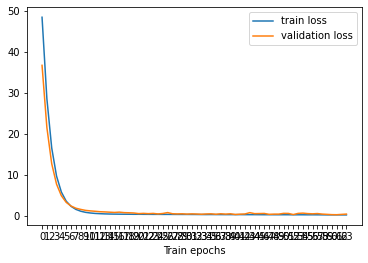

In [81]:
def train_and_evaluate(
  df_x_train=X_train,
  df_y_train=y_train,
  df_x_test=X_val,
  df_y_test=y_val
  ):

  # Build the model.
  #with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = build_model()

  # Train the model.
  print('Training...')

  history = model.fit(
    x=df_x_train,
    y=df_y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    verbose=1
    )
    
  # Retrieve training metrics (after each train epoch) and the final test accuracy
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.plot(train_loss, label='train loss')
  plt.plot(val_loss, label='validation loss')
  plt.xticks(range(NUM_EPOCHS))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_metrics = model.evaluate(
    x=df_x_test,
    y=df_y_test,
    verbose=0,
    return_dict=True
    )
  
  return model, test_metrics

fit, test_metrics = train_and_evaluate()

# IV. Evaluating the Model

In [82]:
test_metrics

{'loss': 0.422247052192688,
 'auc': 0.8918395042419434,
 'pre': 0.17123942077159882,
 'rec': 0.7574426531791687}

5537/5537 [==============================] - 20s 4ms/step


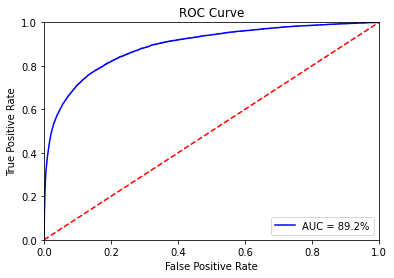

In [83]:
fpr, tpr, threshold = roc_curve(y_val, fit.predict(X_val))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.1%}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# V. Outputting Model

In [84]:
preds1 = fit.predict(test.iloc[:250000])
preds2 = fit.predict(test.iloc[250000:])
preds = np.concatenate((preds1, preds2), axis=0)
sub['isFraud'] = preds

8022/8022 [==============================] - 32s 4ms/step


In [106]:
from google.colab import files
sub.to_csv('keras_nn_submission.csv', index=False)
files.download('keras_nn_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import runtime
runtime.unassign()